In [1]:
import pandas as pd
import numpy as np
import missingno as msno
import lifelines
import matplotlib.pyplot as plt

First, we read in all the data for the orphan wells and make a few minor type conversions. 

In [2]:
dataset=pd.read_csv('orphans_df_surv_new.csv', dtype=str)
dataset['days_active']=dataset['days_active'].astype(int)
dataset['api_depth']=dataset['api_depth'].astype(int)
dataset['active']=1
dataset['og_code']=dataset['og_code'].astype(bool)
dataset['p5_renewal_month']=dataset['p5_renewal_month'].astype(int)
dataset['p5_renewal_year']=dataset['p5_renewal_year'].astype(int)
dataset['violation_counts']=dataset['violation_counts'].astype(int)
dataset.drop(['w2g1_date', 'w2g1_filed_date', 'completion_date', 'p5_org_status', 'orig_completion', 'shutin_dt'], axis=1, inplace=True)
dataset['date_built']=pd.to_datetime(dataset['date_built'])
dataset.head()

,api,og_code,district,county_name,county_no,operator_name,operator_no,lease_name,lease_no,well_no,...,g_salt_dome_flag,violation_counts,operator_tax_cert_flag,operator_sb639_flag,fa_option_code,organization_code,gatherer_code,date_built,tax_cert,days_active
0,34130621,True,10,MOORE,341,"NEW-TEX OPERATING, LLC",606154,THOMPSON -26-,06849,8R,...,N,122,Y,Y,02,H,None,2014-01-23,Y,9506
1,33930854,True,03,MONTGOMERY,339,"VELOCITY OIL AND GAS, LLC",884469,KEMPERS,138664,1,...,N,29,Y,Y,02,H,None,2012-09-26,Y,3273
2,34130018,True,10,MOORE,341,PETRO HALEY,660062,SNEED,03633,3,...,N,102,Y,Y,02,C,None,1987-10-22,Y,14298
3,34731253,True,06,NACOGDOCHES,347,FULLSPIKE ENERGY LLC,289935,BLAKE ESTATE,112449,1,...,N,310,Y,Y,02,H,None,2016-03-29,Y,11978
4,34132225,True,10,MOORE,341,"NEW-TEX OPERATING, LLC",606154,THOMPSON -26-,06849,9R,...,N,122,Y,Y,02,H,None,2014-01-23,Y,7563


Next, we can read in the data for the active wells and make type conversions again. 


In [3]:
active_wells=pd.read_csv('active_wells_surv.csv', dtype=str)
active_wells['active']=0
active_wells['days_active']=active_wells['days_active'].astype(int)
active_wells['api_depth']=active_wells['api_depth'].astype(int)
active_wells['og_code']=active_wells['og_code'].astype(bool)
active_wells['p5_renewal_month']=active_wells['p5_renewal_month'].astype(int)
active_wells['p5_renewal_year']=active_wells['p5_renewal_year'].astype(int)
active_wells['violation_counts']=active_wells['violation_counts'].astype(int)
active_wells.drop(['w2g1_date', 'w2g1_filed_date', 'completion_date', 'p5_org_status', 'orig_completion', 'shutin_dt'], axis=1, inplace=True)
active_wells['date_built']=pd.to_datetime(active_wells['date_built'])

In [4]:
encoded_df_class = pd.concat([active_wells.sample(len(dataset)), dataset]) #merging orphans dataset with active
encoded_df_class.head()

,api,og_code,district,county_name,county_no,operator_name,operator_no,lease_name,lease_no,well_no,...,g_salt_dome_flag,violation_counts,operator_tax_cert_flag,operator_sb639_flag,fa_option_code,organization_code,gatherer_code,date_built,tax_cert,days_active
102735,30134027,True,08,LOVING,301,BPX OPERATING COMPANY,085408,STATE PACIFIC 55-T2-8,52582,W107H,...,N,30,Y,Y,02,A,BPXOC,2019-08-01,Y,906
76981,22732721,True,08,HOWARD,227,AMERICO ENERGY RESOURCES LLC,019752,WALDRON S.,27184,2,...,N,224,Y,Y,02,H,AMERR,1999-01-05,Y,14278
156271,41535464,True,8A,SCURRY,415,CML EXPLORATION LLC,120648,RAFTER C,70904,1,...,N,40,Y,Y,02,H,None,2007-10-24,Y,793
203149,50334798,True,09,YOUNG,503,BROWN DARRYL OPERATING L.L.C.,099280,PACE & STRANGE,20971,12,...,N,101,Y,Y,02,H,None,2008-02-27,Y,14674
189289,48133479,True,03,WHARTON,481,REMORA MANAGEMENT LLC,701560,SHELL-BROUSSARD,02892,2,...,N,121,Y,Y,02,H,REMOR,2005-04-07,Y,11080


We use label encoding in order to allow us to utilize categorical variables.

In [5]:
from sklearn.utils import shuffle
def encode_df(data):
    data = shuffle(data)
    data.reset_index(inplace=True, drop=True)
    for col in data.columns:
        if data[col].dtype == 'object': 
            codes, uniques = pd.factorize(data[col], )
            data[col] = codes
        elif data[col].dtype == bool:
            data[col] = data[col].replace({True: 1, False: 0})
        elif str(data[col].dtype) == 'Int64' or data[col].dtype == np.int64 or data[col].dtype == np.float64:
            data[col] = data[col]
        else: # for datetimes - change datetime data to number of days from the start date in the data.
            data[col] = (data[col] - data[col].min()) / np.timedelta64(1, 'D')
    return data

In [6]:
encoded_dataset = encode_df(encoded_df_class)

In [7]:
encoded_dataset.drop(["well_type_name","operator_sb639_flag"], axis=1)

,api,og_code,district,county_name,county_no,operator_name,operator_no,lease_name,lease_no,well_no,...,o_salt_dome_flag,g_salt_dome_flag,violation_counts,operator_tax_cert_flag,fa_option_code,organization_code,gatherer_code,date_built,tax_cert,days_active
0,0,1,0,0,0,0,0,0,0,0,...,0,0,61,0,0,0,0,13765.0,0,5556
1,1,1,1,1,1,1,1,1,1,1,...,0,0,98,0,0,0,0,13937.0,0,3501
2,2,1,2,2,2,2,2,2,2,2,...,0,0,31,0,0,1,0,5367.0,0,18402
3,3,1,3,3,3,3,3,3,3,3,...,0,0,18,0,0,2,0,3212.0,0,9643
4,4,1,4,4,4,4,4,4,4,4,...,0,0,65,0,0,0,0,13920.0,0,2508
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7119,7080,1,6,35,35,1151,1151,4462,5120,408,...,0,0,148,0,0,2,223,4470.0,0,8167
7120,7081,1,6,35,35,183,183,823,5482,435,...,0,0,102,0,0,1,0,4507.0,0,7680
7121,7082,1,5,94,95,111,111,1189,5483,26,...,0,0,15,0,0,0,0,16425.0,0,7196
7122,7083,1,10,80,80,1191,1191,4069,5484,435,...,0,0,8,0,0,0,0,14745.0,0,162


Now we can start fitting models to our data. The first model is called the WeibullAFTFitter, and it assumes that the data conforms to a Weibull distribution. The 'duration column' is the factor we wish to predict (in this case, the longevity of a well/how long it stays active) and the 'event column' indicates whether the death event has been observed. 

In [8]:
from lifelines import WeibullAFTFitter
wft = WeibullAFTFitter()
wft.fit(encoded_dataset, duration_col='days_active', event_col='active', show_progress=True)
wft.print_summary()

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 5.213162694848029
            Iterations: 58
            Function evaluations: 68
            Gradient evaluations: 58
     fun: 5.213162694848029
     jac: array([-1.28519078e-07,  6.54086625e-08, -2.41528348e-07, -1.48996715e-07,
       -1.61589428e-06, -8.43598721e-07, -1.47016286e-07, -1.68240340e-07,
       -1.89132110e-06, -3.65388843e-07, -3.75784300e-07,  9.45200241e-08,
        3.03367512e-07, -6.37029672e-08, -7.44769943e-08, -1.24036485e-08,
       -5.05726919e-08,  1.59290322e-06,  1.23682596e-06,  0.00000000e+00,
       -3.34548472e-07, -3.34548472e-07,  1.88580301e-06,  0.00000000e+00,
       -1.79652991e-07, -2.64899348e-07, -1.14743101e-03, -1.17742253e-07,
       -3.45919393e-07, -1.17742253e-07, -3.45919393e-07,  1.55525421e-07,
       -4.21741993e-07,  1.39878854e-07, -9.25780397e-07, -1.19283130e-08,
        0.00000000e+00,  1.59290322e-06,  9.35666431e-08])
 message: 'Optimiz

/Applications/anaconda3/lib/python3.8/site-packages/lifelines/fitters/__init__.py:2042: ApproximationWarning: The Hessian was not invertible. We will instead approximate it using the pseudo-inverse.

It's advisable to not trust the variances reported, and to be suspicious of the fitted parameters too.

Some ways to possible ways fix this:

0. Are there any lifelines warnings outputted during the `fit`?
1. Does a particularly large variable need to be centered to 0?
2. Inspect your DataFrame: does everything look as expected? Do you need to add/drop a constant (intercept) column?
3. Is there high-collinearity in the dataset? Try using the variance inflation factor (VIF) to find redundant variables.
4. Trying adding a small penalizer (or changing it, if already present). Example: `WeibullAFTFitter(penalizer=0.01).fit(...)`.
5. Are there any extreme outliers? Try modeling them or dropping them to see if it helps convergence.

  warnings.warn(warning_text, exceptions.ApproximationWarning)


<lifelines.WeibullAFTFitter: fitted with 7124 total observations, 3562 right-censored observations>
             duration col = 'days_active'
                event col = 'active'
   number of observations = 7124
number of events observed = 3562
           log-likelihood = -37138.57
         time fit was run = 2021-07-23 01:52:41 UTC

---
                                    coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
param   covariate                                                                                                                         
lambda_ api                        -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
        api_depth                  -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
        county_name                 0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
        county_no                  -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
        date_built                 -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
        district                    0.01       1.01       0.00             0.00             0.02                 1.00                 1.02
        fa_option_code             -0.15       0.86       0.01            -0.18            -0.12                 0.84                 0.89
        field_class                -0.04       0.96       0.02            -0.07            -0.01                 0.93                 0.99
        field_h2s_flag              0.15       1.16       0.02             0.12             0.18                 1.12                 1.20
        field_name                  0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
        field_no                   -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
        g_salt_dome_flag            0.18       1.20       0.26            -0.34             0.69                 0.72                 2.00
        gatherer_code               0.00       1.00       0.00             0.00             0.01                 1.00                 1.01
        lease_name                  0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
        lease_no                   -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
        multi_comp_flag             0.16       1.18       0.06             0.04             0.29                 1.04                 1.34
        o_salt_dome_flag           -0.25       0.78       0.28            -0.79             0.29                 0.46                 1.34
        og_code                     9.57   14379.38      46.85           -82.24           101.39                 0.00             1.08e+44
        oil_unit_no                 0.15       1.17       0.03             0.10             0.21                 1.11                 1.23
        on_schedule                -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
        operator_name               0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
        operator_no                 0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
        operator_sb639_flag         0.25       1.28       0.04             0.17             0.33                 1.18                 1.39
        operator_tax_cert_flag     -0.00       1.00        nan              nan              nan                  nan                  nan
        organization_code          -0.01      

Although concordance is a relative measure, this concordance value is fairly strong; the concordance value for most models typically ranges from 0.55 to 0.75.

We can try evaluating these results using k-fold cross validation, with decent results. 

In [9]:
from lifelines.utils import k_fold_cross_validation
scores = k_fold_cross_validation(wft, encoded_dataset, 'days_active', event_col='active', k=3, scoring_method="concordance_index")
print(scores)

/Applications/anaconda3/lib/python3.8/site-packages/lifelines/fitters/__init__.py:2042: ApproximationWarning: The Hessian was not invertible. We will instead approximate it using the pseudo-inverse.

It's advisable to not trust the variances reported, and to be suspicious of the fitted parameters too.

Some ways to possible ways fix this:

0. Are there any lifelines warnings outputted during the `fit`?
1. Does a particularly large variable need to be centered to 0?
2. Inspect your DataFrame: does everything look as expected? Do you need to add/drop a constant (intercept) column?
3. Is there high-collinearity in the dataset? Try using the variance inflation factor (VIF) to find redundant variables.
4. Trying adding a small penalizer (or changing it, if already present). Example: `WeibullAFTFitter(penalizer=0.01).fit(...)`.
5. Are there any extreme outliers? Try modeling them or dropping them to see if it helps convergence.

  warnings.warn(warning_text, exceptions.ApproximationWarning)


[0.6770804834541552, 0.6866118341716343, 0.6877499001365251]


/Applications/anaconda3/lib/python3.8/site-packages/lifelines/fitters/__init__.py:2042: ApproximationWarning: The Hessian was not invertible. We will instead approximate it using the pseudo-inverse.

It's advisable to not trust the variances reported, and to be suspicious of the fitted parameters too.

Some ways to possible ways fix this:

0. Are there any lifelines warnings outputted during the `fit`?
1. Does a particularly large variable need to be centered to 0?
2. Inspect your DataFrame: does everything look as expected? Do you need to add/drop a constant (intercept) column?
3. Is there high-collinearity in the dataset? Try using the variance inflation factor (VIF) to find redundant variables.
4. Trying adding a small penalizer (or changing it, if already present). Example: `WeibullAFTFitter(penalizer=0.01).fit(...)`.
5. Are there any extreme outliers? Try modeling them or dropping them to see if it helps convergence.

  warnings.warn(warning_text, exceptions.ApproximationWarning)


In [11]:
encoded_dataset['p5_renewal_month'].unique()

array([ 2,  8,  4,  7,  5, 12,  9, 11,  6,  3,  1, 10])

We can use the plot_partial_effects_on_outcome method to visualize how individual covariates affect our results. 

Text(0.5, 1.0, 'Depth Regression')

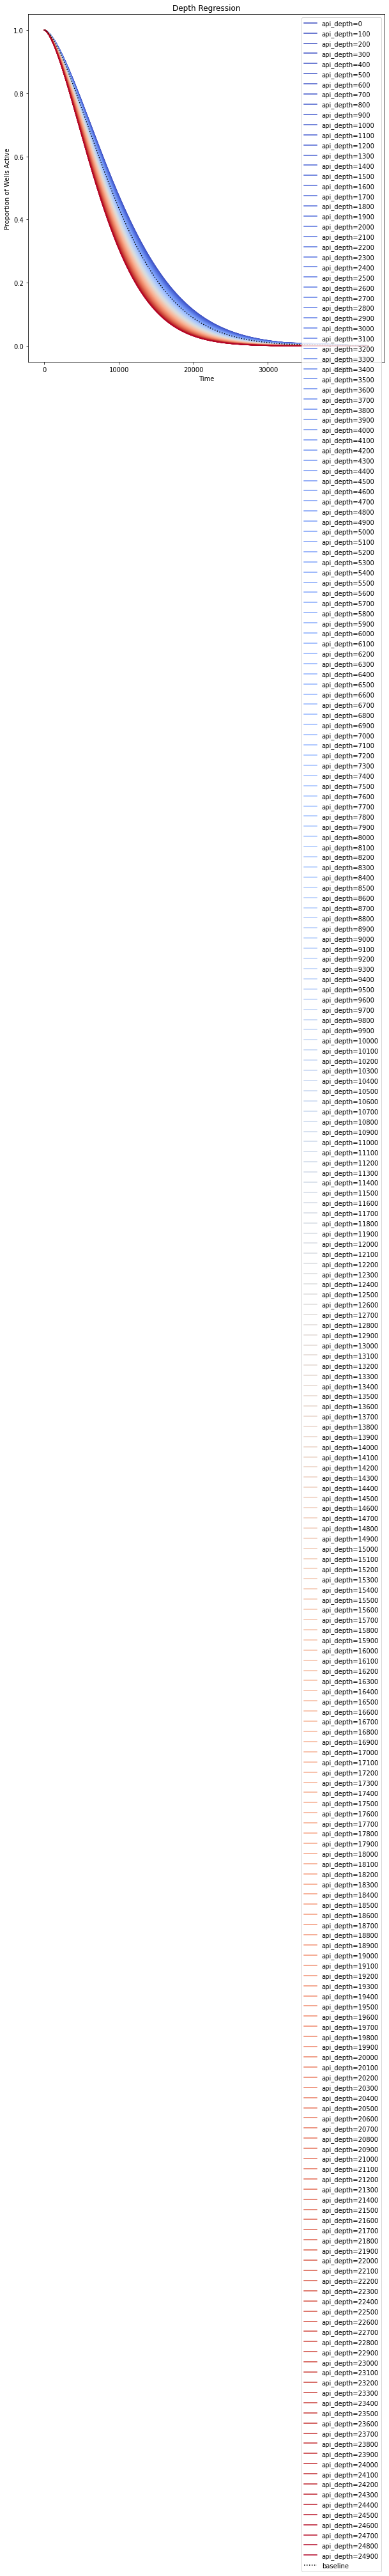

In [12]:
values=[]
for i in range(250):
    i*=100
    values.append(i)
plt.figure(figsize=(10,10))
wft.plot_partial_effects_on_outcome(covariates='api_depth', values=values, cmap='coolwarm')
plt.xlabel('Time')
plt.ylabel('Proportion of Wells Active')
plt.title('Depth Regression')
#plt.savefig('fireapi.png')

Text(0.5, 1.0, 'Tax Cert')

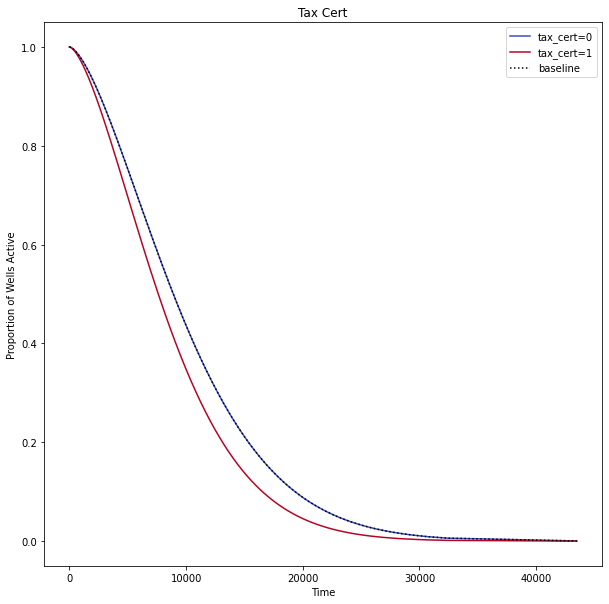

In [13]:
values=[]
for i in range(2):
    values.append(i)
plt.figure(figsize=(10,10))
wft.plot_partial_effects_on_outcome(covariates='tax_cert', values=values, cmap='coolwarm')
plt.xlabel('Time')
plt.ylabel('Proportion of Wells Active')
plt.title('Tax Cert')
#eplt.savefig('Tax Cert.png')

Text(0.5, 1.0, 'Gatherer Code')

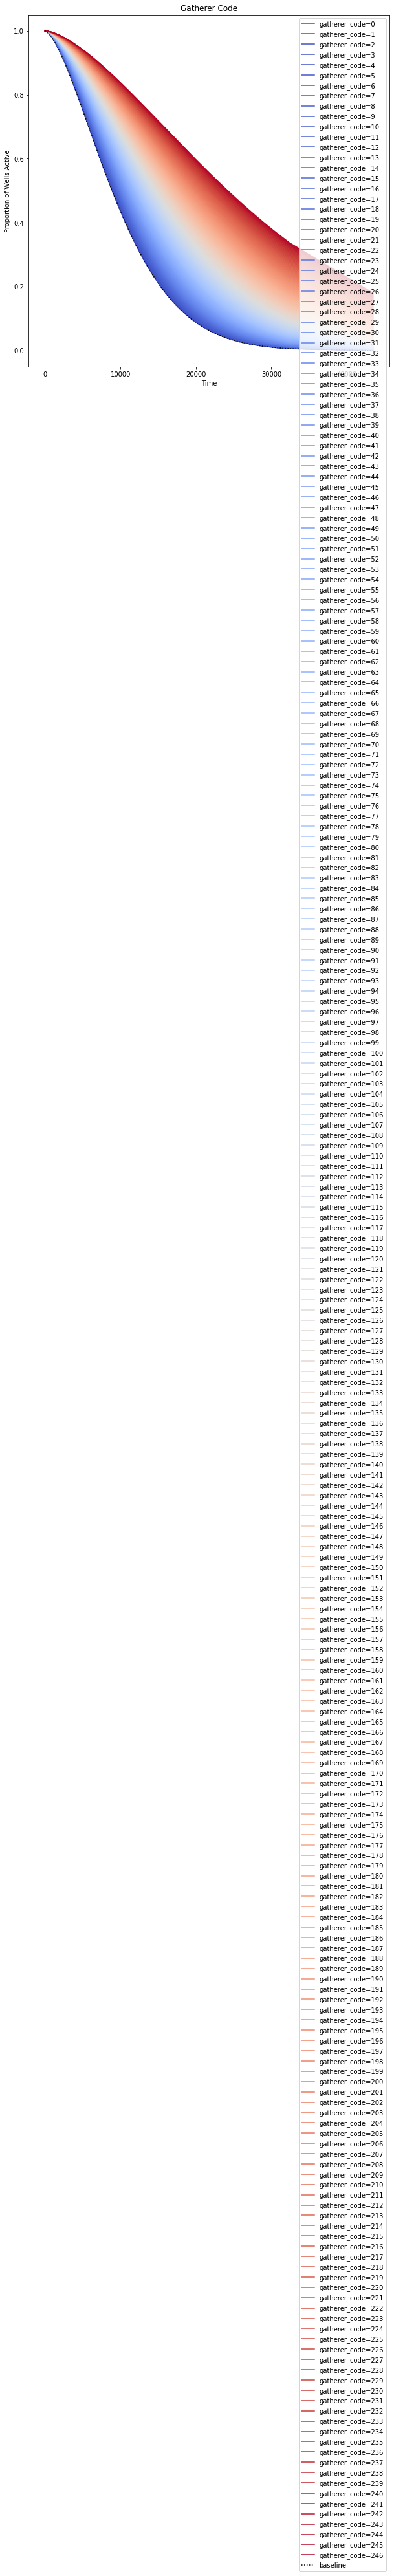

In [14]:
values=[]
for i in range(247):
    values.append(i)
plt.figure(figsize=(10,10))
wft.plot_partial_effects_on_outcome(covariates='gatherer_code', values=values, cmap='coolwarm')
plt.xlabel('Time')
plt.ylabel('Proportion of Wells Active')
plt.title('Gatherer Code')
#plt.savefig('gatherercode.png')

Text(0.5, 1.0, 'Org Code')

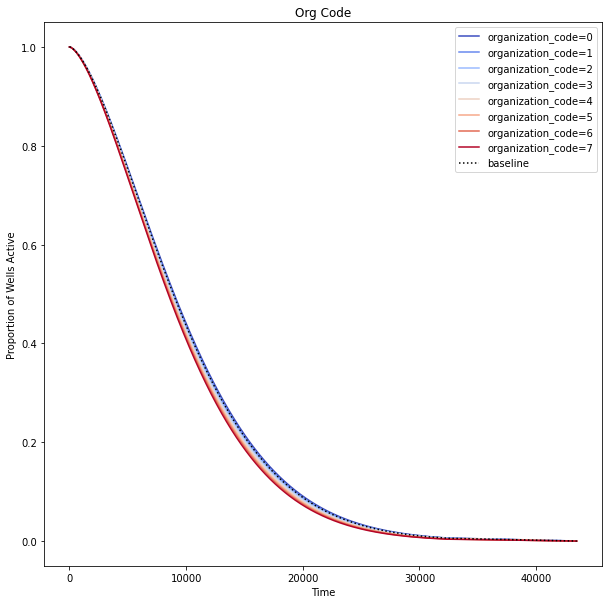

In [15]:
values=[]
for i in range(8):
    values.append(i)
plt.figure(figsize=(10,10))
wft.plot_partial_effects_on_outcome(covariates='organization_code', values=values, cmap='coolwarm')
plt.xlabel('Time')
plt.ylabel('Proportion of Wells Active')
plt.title('Org Code')
#plt.savefig('Organization_Code')

Text(0.5, 1.0, 'FA Option Code')

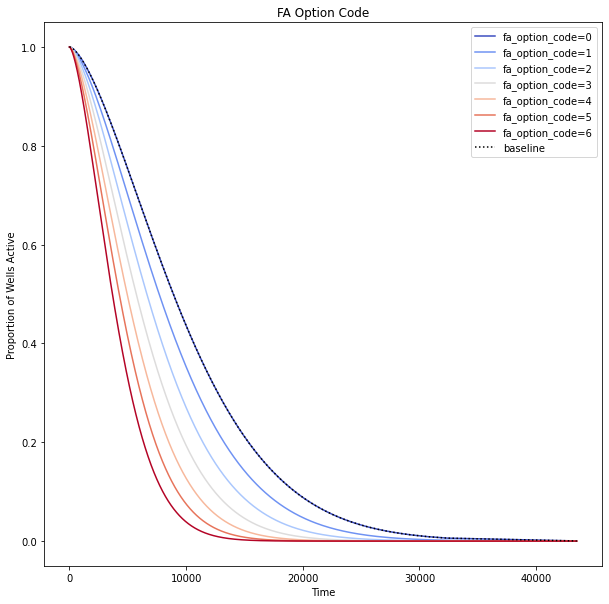

In [16]:
values=[]
for i in range(7):
    values.append(i)
plt.figure(figsize=(10,10))
wft.plot_partial_effects_on_outcome(covariates='fa_option_code', values=values, cmap='coolwarm')
plt.xlabel('Time')
plt.ylabel('Proportion of Wells Active')
plt.title('FA Option Code')
#plt.savefig('fa option code.png')

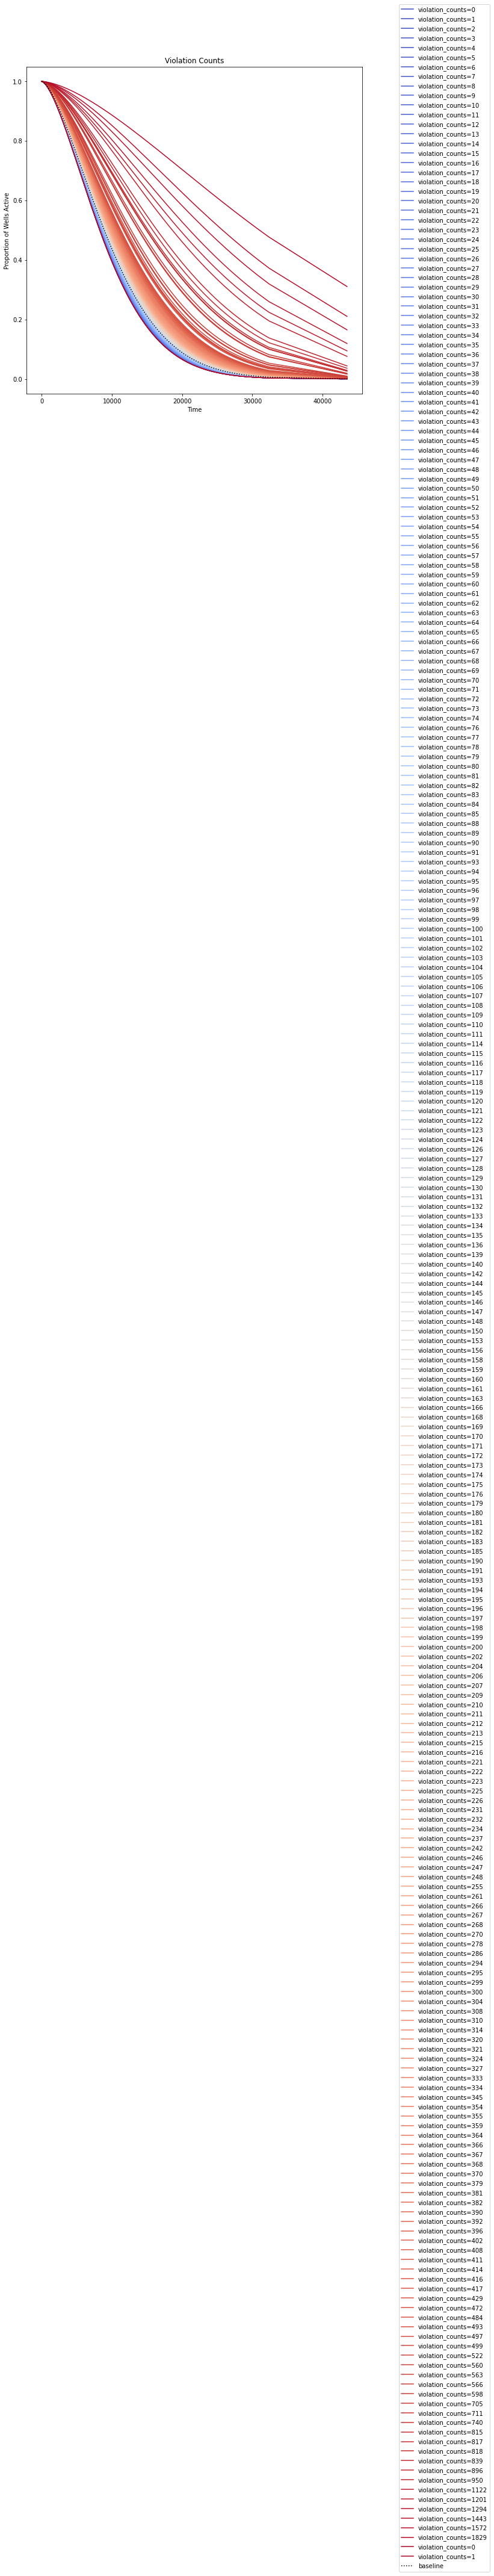

In [45]:
values=[ 13, 1443,   84,   54,  194,  359,   61,  396,   19,  133,  215,
        182,   50,   94,   42,  310,   20,   41,  223, 1122,  174,  207,
         30,  135,   18,   88,   12,    0,  429,  232,  172,  121,  382,
         44,  711,  497,  148,   28,  493,  117,   32,   52,  705,   45,
         90,   69,   70,   23,  226,   62,    1,   93,    3,   55,  111,
         33,   78,   66,    9,  183,  300,  225,  146,  472,  237,  128,
         47,   14,   21,   15,  200,  190,  180,   27,    4,  327,  278,
         26,   10,  950,  598,  170,   34,   35,   16,   49,  411,   83,
        354,   24,  107,   58,  484,   25,  179,  156,  197,  102,  136,
         60,  247,  740,  104,  115,   22,   29,    7, 1572,  140, 1201,
        839,   89,  522,  563,  105,  181,  114,  314,  817,   11,    5,
        132,  270,  166,  320,    6,  417,   74, 1829,   36,  499,  212,
         31,  261,  161,   65,    8,  267,  163,  355,  173,  211,   80,
         39,  168,  209,  185,  379,  193,  294,   17,   98,  122,    2,
         77,   73,  109,   79,   82,  159,  108,  333, 1294,   38,  126,
        150,  560,   46,   37,  408,   53,  392,  248,  390,  110,  231,
        119,  145,  896,  160,  103,   81,   68,   97,   64,   57,  818,
        198,  266,  206,   48,  221,   59,   85,  100,  213,  268,  175,
         95,  130,   91,  142,  139,   99,  210,  334,  153,  216,  321,
         43,   40,  176,  134,  191,   51,  308,  255,  196,   71,  129,
        367,  324,  124,   72,  106,   96,  199,  204,  370,  202,  368,
         63,  169,  304,  299,  234,  195,  118,  144,  345,  222,   67,
        414,  402,  295,  147,  381,  123,   56,  120,  364,  366,  127,
        286,  242,  416,  101,  158,  246,  171,  131,  566,  116,   76,
        815]
values.sort()
for i in range(2):
    values.append(i)
fig, ax=plt.subplots(nrows=1, ncols=1, figsize=(10,10))
wft.plot_partial_effects_on_outcome(covariates='violation_counts', values=values, cmap='coolwarm', ax=ax)
plt.xlabel('Time')
plt.ylabel('Proportion of Wells Active')
plt.title('Violation Counts')
ax.legend(bbox_to_anchor=(1.1,1.2))
plt.savefig('violationcounts.png')

Text(0.5, 1.0, 'Gas salt dome flag')

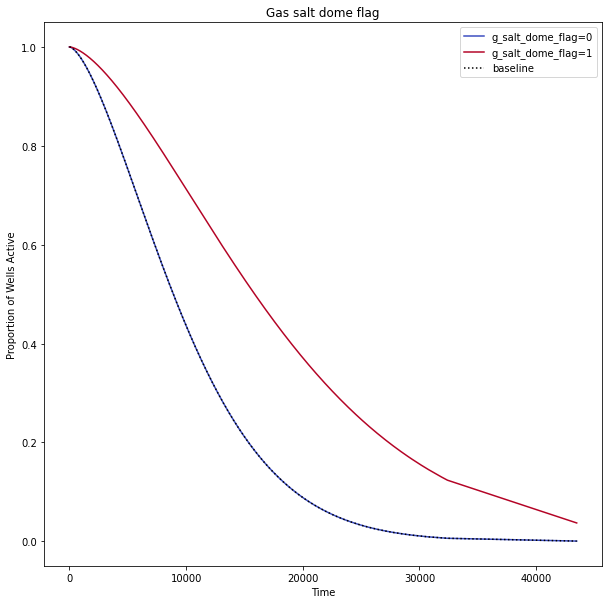

In [18]:
values=[]
for i in range(2):
    values.append(i)
plt.figure(figsize=(10,10))
wft.plot_partial_effects_on_outcome(covariates='g_salt_dome_flag', values=values, cmap='coolwarm')
plt.xlabel('Time')
plt.ylabel('Proportion of Wells Active')
plt.title('Gas salt dome flag')
#plt.savefig('gsd flag.png')

Text(0.5, 1.0, 'O_salt_dome_flag')

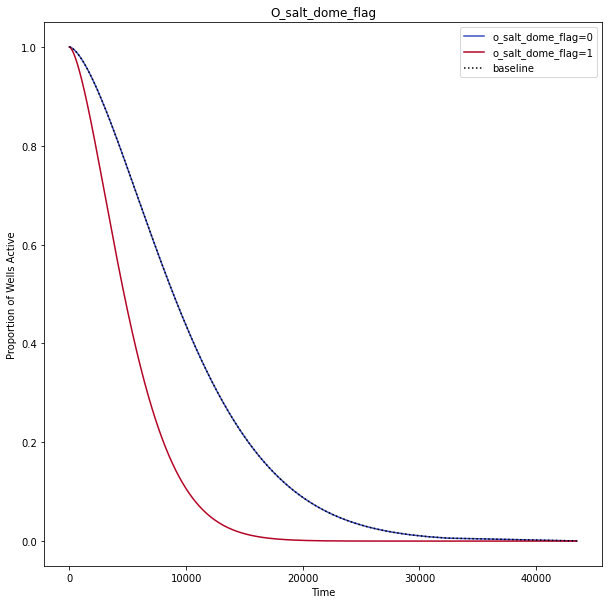

In [19]:
values=[]
for i in range(2):
    values.append(i)
plt.figure(figsize=(10,10))
wft.plot_partial_effects_on_outcome(covariates='o_salt_dome_flag', values=values, cmap='coolwarm')
plt.xlabel('Time')
plt.ylabel('Proportion of Wells Active')
plt.title('O_salt_dome_flag')
#plt.savefig('Oil sd flag.png')

Text(0.5, 1.0, 'Field_h2s_flag')

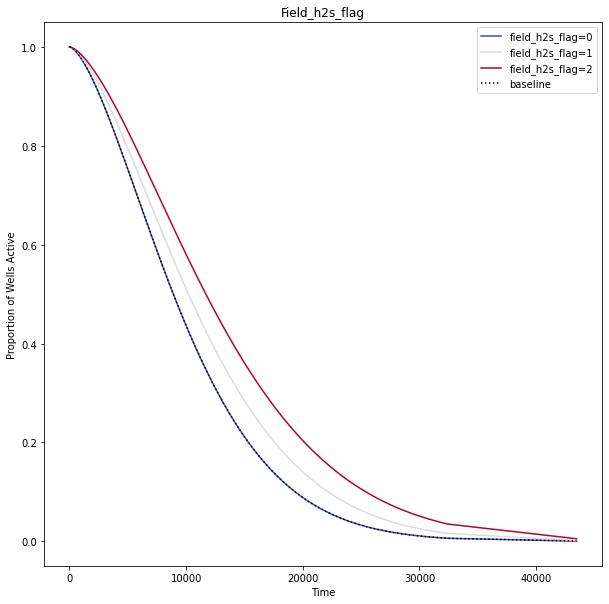

In [20]:
values=[]
for i in range(3):
    values.append(i)
plt.figure(figsize=(10,10))
wft.plot_partial_effects_on_outcome(covariates='field_h2s_flag', values=values, cmap='coolwarm')
plt.xlabel('Time')
plt.ylabel('Proportion of Wells Active')
plt.title('Field_h2s_flag')
#plt.savefig('fieldh2sflag.png')

Text(0.5, 1.0, 'Field Class')

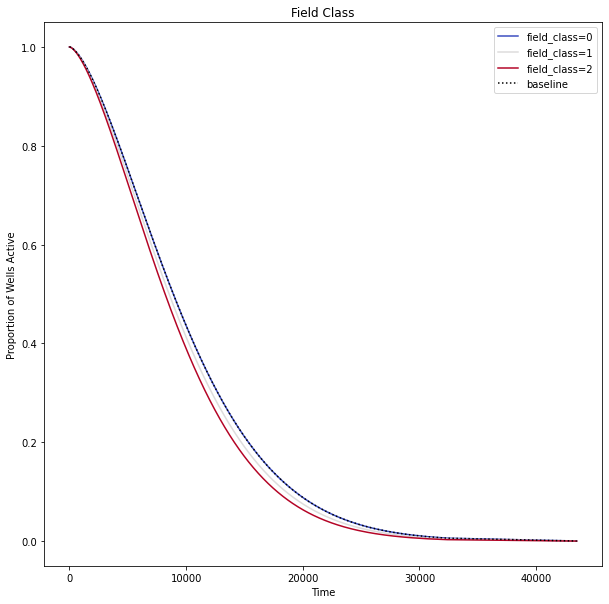

In [21]:
values=[]
for i in range(3):
    values.append(i)
plt.figure(figsize=(10,10))
wft.plot_partial_effects_on_outcome(covariates='field_class', values=values, cmap='coolwarm')
plt.xlabel('Time')
plt.ylabel('Proportion of Wells Active')
plt.title('Field Class')
#plt.savefig('field_class.png')


Text(0.5, 1.0, 'P5 Renewal Year')

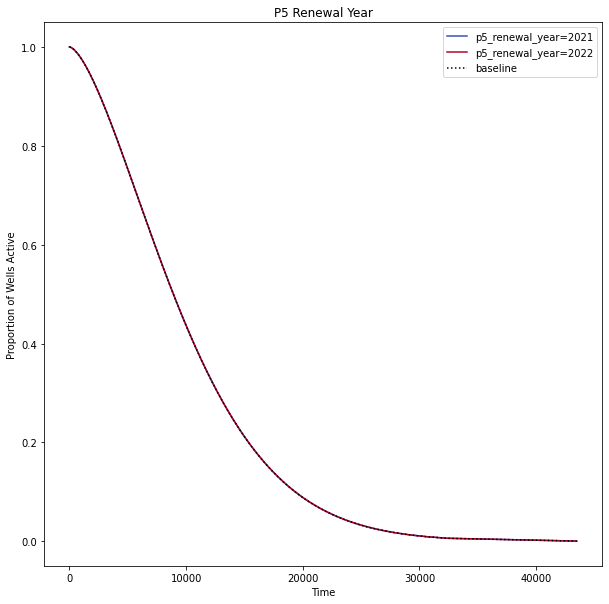

In [22]:
values=[]
for i in range(2):
    values.append(i)
plt.figure(figsize=(10,10))
wft.plot_partial_effects_on_outcome(covariates='p5_renewal_year', values=[2021,2022], cmap='coolwarm')
plt.xlabel('Time')
plt.ylabel('Proportion of Wells Active')
plt.title('P5 Renewal Year')
#plt.savefig('p5year.png')

Text(0.5, 1.0, 'P5 Renewal Month')

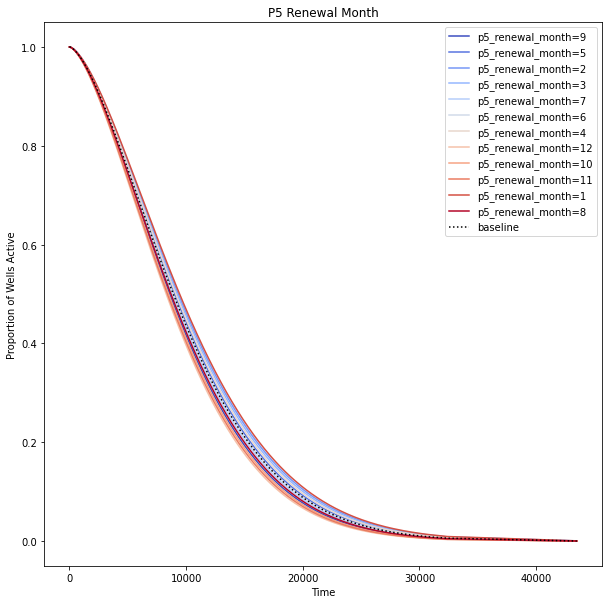

In [23]:
values=[]
for i in range(12):
    values.append(i)
plt.figure(figsize=(10,10))
wft.plot_partial_effects_on_outcome(covariates='p5_renewal_month', values=[9,5,2,3,7,6,4,12,10,11,1,8], cmap='coolwarm')
plt.xlabel('Time')
plt.ylabel('Proportion of Wells Active')
plt.title('P5 Renewal Month')
#plt.savefig('p5renewalmonth.png')

Text(0.5, 1.0, 'Plug Lease Name')

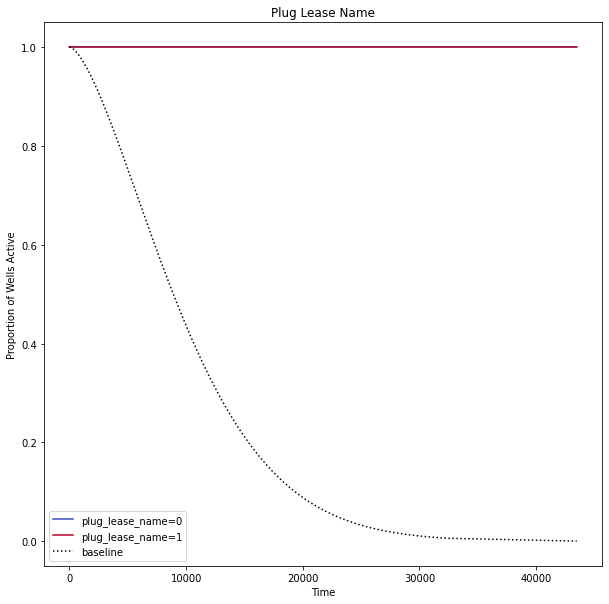

In [24]:
values=[]
for i in range(2):
    values.append(i)
plt.figure(figsize=(10,10))
wft.plot_partial_effects_on_outcome(covariates='plug_lease_name', values=values, cmap='coolwarm')
plt.xlabel('Time')
plt.ylabel('Proportion of Wells Active')
plt.title('Plug Lease Name')
#plt.savefig('pluglease.png')

Text(0.5, 1.0, 'Water Land Code')

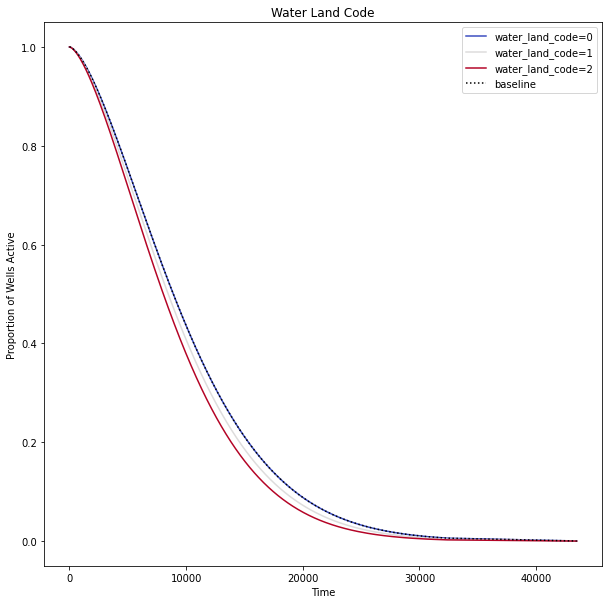

In [25]:
values=[]
for i in range(3):
    values.append(i)
plt.figure(figsize=(10,10))
wft.plot_partial_effects_on_outcome(covariates='water_land_code', values=values, cmap='coolwarm')
plt.xlabel('Time')
plt.ylabel('Proportion of Wells Active')
plt.title('Water Land Code')
#plt.savefig('pluglease.png')

In [26]:
#plt.savefig("DEPTH WFT")

Text(0.5, 1.0, 'Date Built')

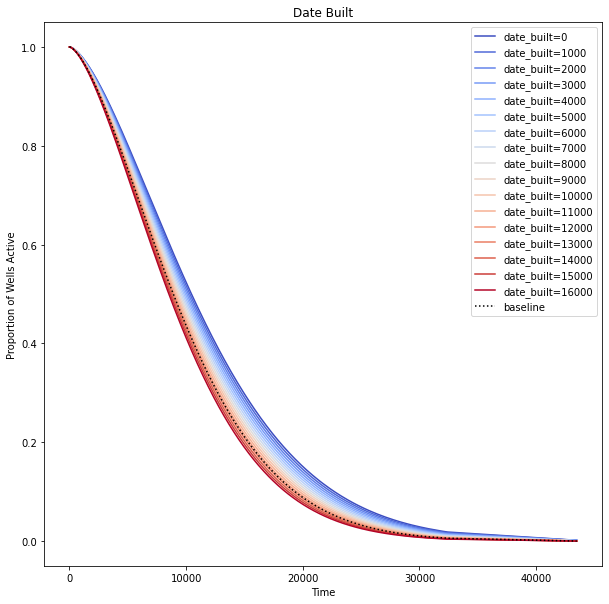

In [27]:
values=[]
for i in range(17):
    i*=1000
    values.append(i)
plt.figure(figsize=(10,10))
wft.plot_partial_effects_on_outcome(covariates='date_built', values=values, cmap='coolwarm')
plt.xlabel('Time')
plt.ylabel('Proportion of Wells Active')
plt.title('Date Built')
#plt.savefig('datebuilt.png')

In [28]:
#plt.savefig("DATEBUILT REGR")

We can see that there is a clear trend indicating that wells with higher depths regress faster than wells that are more shallow. Furthermore, older wells seem to regress faster than younger ones, although this trend is not very strong. 

We can test a few more distribution-based models, such as the LogLogisticAFTFitter and LogNormalAFTFitter. These models (as their name suggest) assume that the data conforms to a particular kind of distribution - either log-logistic or log-normal. 

In [29]:
from lifelines import LogLogisticAFTFitter
llf = LogLogisticAFTFitter(fit_intercept=False)
llf.fit(encoded_dataset, duration_col='days_active', event_col='active')

/Applications/anaconda3/lib/python3.8/site-packages/lifelines/fitters/__init__.py:2042: ApproximationWarning: The Hessian was not invertible. We will instead approximate it using the pseudo-inverse.

It's advisable to not trust the variances reported, and to be suspicious of the fitted parameters too.

Some ways to possible ways fix this:

0. Are there any lifelines warnings outputted during the `fit`?
1. Does a particularly large variable need to be centered to 0?
2. Inspect your DataFrame: does everything look as expected? Do you need to add/drop a constant (intercept) column?
3. Is there high-collinearity in the dataset? Try using the variance inflation factor (VIF) to find redundant variables.
4. Trying adding a small penalizer (or changing it, if already present). Example: `LogLogisticAFTFitter(penalizer=0.01).fit(...)`.
5. Are there any extreme outliers? Try modeling them or dropping them to see if it helps convergence.

  warnings.warn(warning_text, exceptions.ApproximationWarni

<lifelines.LogLogisticAFTFitter: fitted with 7124 total observations, 3562 right-censored observations>

In [30]:
from lifelines import LogNormalAFTFitter
lnf = LogNormalAFTFitter(fit_intercept=False)
lnf.fit(encoded_dataset, duration_col='days_active', event_col='active')

/Applications/anaconda3/lib/python3.8/site-packages/lifelines/fitters/__init__.py:2042: ApproximationWarning: The Hessian was not invertible. We will instead approximate it using the pseudo-inverse.

It's advisable to not trust the variances reported, and to be suspicious of the fitted parameters too.

Some ways to possible ways fix this:

0. Are there any lifelines warnings outputted during the `fit`?
1. Does a particularly large variable need to be centered to 0?
2. Inspect your DataFrame: does everything look as expected? Do you need to add/drop a constant (intercept) column?
3. Is there high-collinearity in the dataset? Try using the variance inflation factor (VIF) to find redundant variables.
4. Trying adding a small penalizer (or changing it, if already present). Example: `LogNormalAFTFitter(penalizer=0.01).fit(...)`.
5. Are there any extreme outliers? Try modeling them or dropping them to see if it helps convergence.

  warnings.warn(warning_text, exceptions.ApproximationWarning

<lifelines.LogNormalAFTFitter: fitted with 7124 total observations, 3562 right-censored observations>

We can plot the general results of these models (the overall survival regression plot). 

Text(0.5, 1.0, 'Survival Regressors')

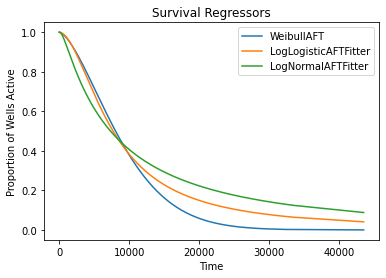

In [31]:
X = encoded_dataset.loc[0]
ax=wft.predict_survival_function(X).rename(columns={0:'WeibullAFT'}).plot()
llf.predict_survival_function(X).rename(columns={0:'LogLogisticAFTFitter'}).plot(ax=ax)
lnf.predict_survival_function(X).rename(columns={0:'LogNormalAFTFitter'}).plot(ax=ax)
plt.xlabel('Time')
plt.ylabel('Proportion of Wells Active')
plt.title('Survival Regressors')

In [32]:
#plt.savefig("THREEFITTERS.png")

In [33]:
from lifelines import AalenAdditiveFitter

aaf = AalenAdditiveFitter(coef_penalizer=1.0, fit_intercept=False)
aaf.fit(encoded_dataset, duration_col='days_active', event_col='active', show_progress=True)

aaf.print_summary()  # access the individual results using cph.summary

Iteration 3101/3109, seconds_since_start = 3.87Convergence completed.


<lifelines.AalenAdditiveFitter: fitted with 7124 total observations, 3562 right-censored observations>
             duration col = 'days_active'
                event col = 'active'
           coef penalizer = 1.0
       number of subjects = 7124
number of events observed = 3562
         time fit was run = 2021-07-23 01:54:18 UTC

---
Empty DataFrame
Columns: []
Index: [api, og_code, district, county_name, county_no, operator_name, operator_no, lease_name, lease_no, well_no, field_name, field_no, oil_unit_no, water_land_code, multi_comp_flag, api_depth, well_type_name, plug_lease_name, plug_operator_name, recent_permit_lease_name, recent_permit_operator_no, on_schedule, p5_renewal_month, p5_renewal_year, field_class, field_h2s_flag, wildcat_flag, o_salt_dome_flag, g_salt_dome_flag, violation_counts, operator_tax_cert_flag, operator_sb639_flag, fa_option_code, organization_code, gatherer_code, date_built, tax_cert]
---
Concordance = 0.59

In [35]:
from lifelines.utils import k_fold_cross_validation
scores = k_fold_cross_validation(aaf, encoded_dataset, 'days_active', event_col='active', k=3, scoring_method="concordance_index")
print(scores)

[0.6343287671867294, 0.6226795467116423, 0.6709521332471808]


In [36]:
aaf.cumulative_hazards_.head() #view cumulative hazards

covariate,api,og_code,district,county_name,county_no,operator_name,operator_no,lease_name,lease_no,well_no,...,o_salt_dome_flag,g_salt_dome_flag,violation_counts,operator_tax_cert_flag,operator_sb639_flag,fa_option_code,organization_code,gatherer_code,date_built,tax_cert
1.0,1.341225e-07,-0.000114,-0.000344,0.000005,0.000005,0.000003,0.000003,2.455137e-08,3.872869e-07,-1.092009e-06,...,-0.000650,0.000511,-4.309836e-07,0.0,-0.000272,-0.000475,-0.000058,4.146578e-06,-6.876490e-09,0.000306
2.0,1.434658e-07,0.000455,0.000028,0.000019,-0.000014,0.000002,0.000002,1.151348e-07,1.151238e-07,-1.278446e-08,...,0.001363,-0.003463,-1.383941e-06,0.0,-0.000860,0.000902,0.000175,7.151942e-07,-1.073856e-07,-0.006603
4.0,5.662838e-08,0.000390,-0.000068,0.000024,-0.000014,0.000004,0.000004,1.052361e-07,1.089798e-07,-1.521870e-07,...,0.001736,-0.004039,-1.139096e-06,0.0,-0.000839,0.001542,-0.000087,-2.218279e-06,-1.006531e-07,-0.009867
5.0,-1.100233e-07,0.000873,-0.000241,0.000040,-0.000024,0.000007,0.000007,-2.202972e-07,5.031761e-07,-1.431122e-06,...,0.016328,-0.002473,-1.313732e-06,0.0,0.000646,0.001063,0.000053,-2.256471e-05,5.735734e-08,-0.011756
6.0,-9.781363e-08,0.000711,0.000027,0.000065,-0.000053,0.000008,0.000008,6.517659e-08,3.476183e-07,-1.779912e-06,...,0.016295,-0.003868,-1.225421e-06,0.0,0.000323,0.000909,0.000171,-2.996324e-05,1.280107e-07,-0.012440


We can use the predict_survival_function method to generate predictions for survival percentages at different discrete time steps. Here, we do so for the wells in the first county. 

In [37]:
df=aaf.predict_survival_function(encoded_dataset.loc[encoded_dataset['county_name']==0])
df

,0,21,113,368,444,472,474,583,697,806,...,5879,5900,5956,5999,6249,6330,6370,6637,6793,7059
1.0,0.999413,0.998370,0.997645,1.000584,0.997849,0.997874,0.997550,1.000491,0.999381,0.999137,...,0.999791,0.996961,0.997433,0.999768,1.000127,1.000418,0.998317,0.995748,0.999433,0.999220
2.0,1.000943,0.996797,0.996725,1.003073,0.997142,0.997182,0.997243,1.003328,0.998094,0.999902,...,1.003000,0.997213,0.998085,1.002942,0.999357,0.999345,0.997677,0.997675,1.000527,1.001169
4.0,1.000337,0.996136,0.995092,1.003381,0.996718,0.996761,0.996690,1.003117,0.997632,0.998867,...,1.003307,0.997464,0.997483,1.003250,0.999887,0.999920,0.996698,0.996882,1.000675,1.001154
5.0,0.999797,0.995137,0.992632,1.002683,0.995411,0.995437,0.992969,1.001557,0.997160,0.996175,...,1.003114,0.997989,0.994256,1.003065,1.001970,1.002381,0.994099,0.993635,0.998522,1.001382
6.0,1.000863,0.996180,0.993366,1.004668,0.995976,0.995996,0.992898,1.003351,0.998439,0.997500,...,1.004488,0.998106,0.992439,1.004425,1.003273,1.003773,0.994375,0.994396,0.998174,1.001702
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28989.0,0.035964,0.290932,0.289980,0.063729,0.364436,0.364973,0.277995,0.052193,1.430894,0.521239,...,0.032726,0.458211,0.334982,0.031689,1.329481,1.490062,1.317018,0.064774,0.337681,0.430214
29368.0,0.059517,0.291080,0.290176,0.105592,0.364502,0.365029,0.277899,0.086400,1.433867,0.521780,...,0.054170,0.458006,0.334247,0.052454,1.330064,1.490691,1.025306,0.083334,0.336694,0.553501
31240.0,0.035552,0.289501,0.288841,0.063188,0.362251,0.362785,0.275644,0.051727,1.432649,0.521173,...,0.032443,0.455940,0.334024,0.031413,1.329604,1.490505,1.323972,0.064320,0.335575,0.429463
31799.0,0.070067,0.288633,0.288542,0.124420,0.360498,0.361033,0.274281,0.102042,1.428530,0.521222,...,0.063891,0.453848,0.333697,0.061858,1.327664,1.488665,0.940596,0.090212,0.334094,0.603943


We construct a dataframe called compare that contains the mean predicted survival predictions for the wells in each county. 

In [40]:
compare=pd.DataFrame()
for i in range(203):
    df=aaf.predict_survival_function(encoded_dataset.loc[encoded_dataset['county_name']==i])
    df['mean'] = df.mean(axis=1)
    means=pd.DataFrame()
    compare[str(i)]=df['mean']

In [41]:
compare

,0,1,2,3,4,5,6,7,8,9,...,193,194,195,196,197,198,199,200,201,202
1.0,0.998777,0.999022,0.998743,0.999415,0.999498,0.999819,0.998441,0.998812,0.999567,0.999784,...,0.999318,0.998606,0.997407,0.999044,0.998399,1.000498,1.002178,0.999049,0.997484,0.998680
2.0,0.999432,0.999294,0.998470,0.999450,0.999155,0.999699,0.995789,1.000591,0.997773,0.999965,...,0.999152,0.999239,0.997978,0.999768,1.000809,0.999611,0.999551,0.999314,0.998748,0.998806
4.0,0.999008,0.998949,0.998459,0.999634,0.999014,0.999918,0.995415,1.000204,0.997862,1.000074,...,0.998742,0.998857,0.996726,0.998914,0.999625,0.999510,1.000260,0.998250,0.997641,0.997431
5.0,0.997437,0.997638,0.997763,0.999044,0.998460,1.000426,0.995994,0.998667,0.998020,0.999244,...,0.995484,0.994807,0.994547,0.995287,0.995958,0.996466,0.999998,0.992846,0.994474,0.993259
6.0,0.997811,0.997860,0.998075,0.999144,0.997686,0.999682,0.995237,0.998537,0.996921,0.999741,...,0.993443,0.993785,0.994264,0.992667,0.994257,0.994071,0.998564,0.989866,0.993716,0.991237
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28989.0,0.418609,0.466381,0.610177,0.791784,0.607869,0.724132,0.386395,0.182095,0.623175,0.834822,...,0.365366,1.136377,0.900358,0.718579,0.052417,0.169706,0.695427,0.503133,0.615673,0.021336
29368.0,0.409694,0.432992,0.562827,0.782167,0.600548,0.723936,0.381349,0.182817,0.478432,0.824408,...,0.351169,1.009783,0.901805,0.599497,0.086678,0.186801,0.694341,0.502727,0.615721,0.016586
31240.0,0.418021,0.465700,0.610676,0.791821,0.608048,0.724182,0.385475,0.181587,0.624306,0.834813,...,0.365535,1.143235,0.902721,0.720541,0.052054,0.168649,0.693718,0.503611,0.615834,0.021756
31799.0,0.407099,0.423908,0.549177,0.779447,0.599490,0.724450,0.378894,0.185738,0.443207,0.820312,...,0.350769,0.978797,0.903986,0.570584,0.102912,0.192934,0.693296,0.504849,0.616323,0.015611


Next, we create four "cutoffs" (namely 90%, 75%, 60%, and 45%) and determine if and when the wells in each county reach these probability cutoffs. 

In [34]:
store=[]
for i in range(203):
    temp=list(compare[str(i)])
    a=True
    b=True
    c=True
    d=True
    index=0
    temp2=[]
    while d and index<len(temp):
        if a and temp[index]<0.9: #first cutoff
            temp2.append(index)
            a=False
        if b and temp[index]<0.75: 
            temp2.append(index)
            b=False
        if c and temp[index]<0.6:
            temp2.append(index)
            c=False
        if d and temp[index]<0.45:
            temp2.append(index)
            d=False
        index+=1
    store.append(temp2)
    while len(temp2)!=4:
        temp2.append(39209) #add largest number possible for those that don't meet cutoffs

In [35]:
cutoffs=pd.DataFrame(columns=['County', 'Days', 'Cutoff'])
for i in range(203): #convert data to dataframe
    for j in range(4):
        row=[]
        row.append(i)
        row.append(store[i][j])
        if j==0:
            row.append(0.9)
        if j==1:
            row.append(0.75)
        if j==2:
            row.append(0.5)
        if j==3:
            row.append(0.25)
        cutoffs.loc[len(cutoffs.index)]=row

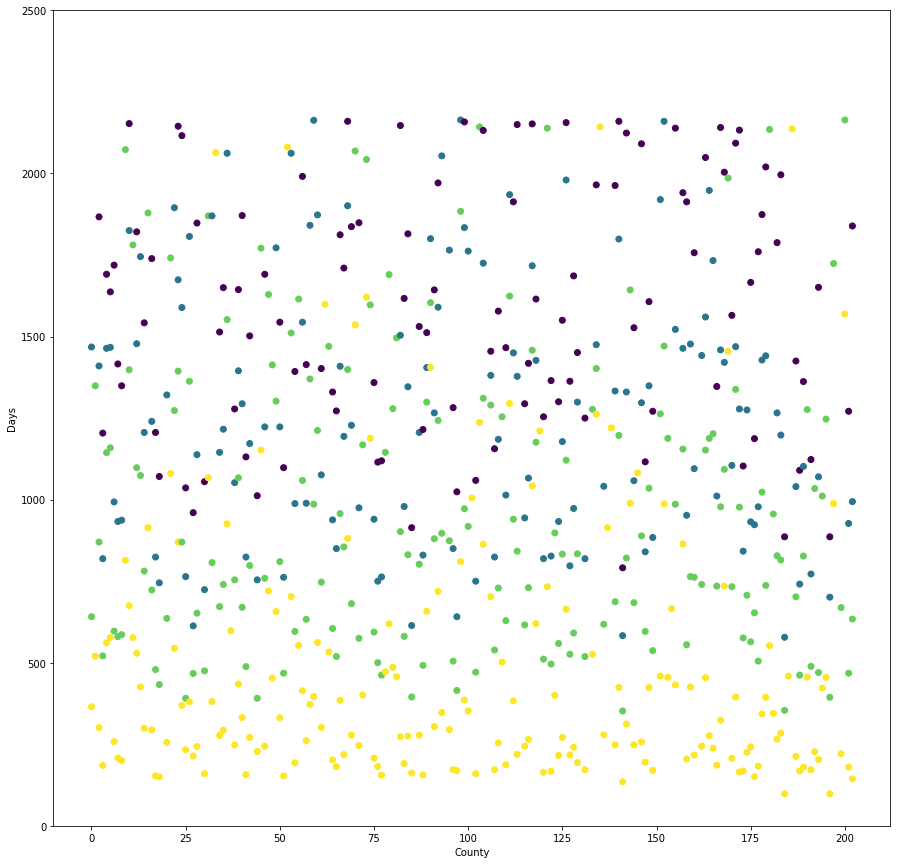

In [112]:
#plot results
plt.figure(figsize=(15,15))
plt.scatter(cutoffs['County'], cutoffs['Days'],c=cutoffs['Cutoff'])
plt.ylim(ymin=0, ymax=2500)
plt.xlabel('County')
plt.ylabel('Days')
plt.savefig("COUNTY.png")

In [52]:
compare2=pd.DataFrame()
for i in range(17):
    val1=1000*i
    val2=1000*i+1000
    df3=aaf.predict_survival_function(encoded_dataset.loc[(encoded_dataset['date_built']>val1) & (encoded_dataset["date_built"]<val2)])
    df3['mean'] = df3.mean(axis=1)
    means=pd.DataFrame()
    compare2[str(i)]=df3['mean']

In [53]:
compare2

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
1.0,0.999457,0.998123,0.999167,0.998622,0.999112,0.999642,0.999024,0.998581,0.999118,1.000113,0.999005,0.998956,0.999025,0.999062,0.999096,0.999292,0.998853
2.0,0.998425,0.996989,0.997519,0.996696,0.998006,0.997684,0.996819,0.997904,0.999472,0.999643,0.998681,0.998364,0.998689,0.999087,0.998783,0.999259,0.999005
4.0,0.998434,0.996770,0.997414,0.996310,0.997964,0.997769,0.996575,0.997667,0.999271,0.999731,0.998670,0.997952,0.998389,0.998727,0.998465,0.999053,0.998678
5.0,0.999110,0.995847,0.996680,0.995484,0.997692,0.997749,0.995498,0.996753,0.998299,0.999549,0.997210,0.996402,0.997040,0.997377,0.997255,0.997993,0.996909
6.0,0.999772,0.995454,0.996542,0.995152,0.997184,0.996892,0.994914,0.996736,0.998461,0.999299,0.997097,0.995892,0.996367,0.996826,0.996687,0.997411,0.996080
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28989.0,0.921986,0.499034,0.485577,0.490376,0.500132,0.457733,0.852261,0.456690,0.769866,0.825922,0.550235,0.540629,0.482849,0.519019,0.510990,0.468433,0.651334
29368.0,0.895979,0.457269,0.465697,0.410999,0.480526,0.449348,0.694256,0.406033,0.740738,0.817108,0.496888,0.491402,0.423872,0.485197,0.456615,0.448098,0.647933
31240.0,0.923594,0.499286,0.485554,0.490775,0.500337,0.457248,0.853933,0.456658,0.770276,0.825968,0.550722,0.541418,0.483340,0.519285,0.511394,0.468598,0.651192
31799.0,0.890769,0.446216,0.460573,0.392555,0.476927,0.447816,0.653627,0.392568,0.733180,0.814418,0.484198,0.479504,0.410265,0.477394,0.443141,0.444278,0.646780


In [54]:
store2=[]
for i in range(17):
    temp=list(compare2[str(i)])
    a=True
    b=True
    c=True
    d=True
    index=0
    temp2=[]
    while d and index<len(temp):
        if a and temp[index]<0.9:
            temp2.append(index)
            a=False
        if b and temp[index]<0.75:
            temp2.append(index)
            b=False
        if c and temp[index]<0.6:
            temp2.append(index)
            c=False
        if d and temp[index]<0.45:
            temp2.append(index)
            d=False
        index+=1
    store2.append(temp2)
    while len(temp2)!=4:
        temp2.append(17000)

In [55]:
cutoffs_built=pd.DataFrame(columns=['Date_Built', 'Days', 'Cutoff'])
for i in range(17):
    for j in range(4):
        row=[]
        row.append(i)
        row.append(store2[i][j])
        if j==0:
            row.append(0.9)
        if j==1:
            row.append(0.75)
        if j==2:
            row.append(0.6)
        if j==3:
            row.append(0.45)
        cutoffs_built.loc[len(cutoffs_built.index)]=row

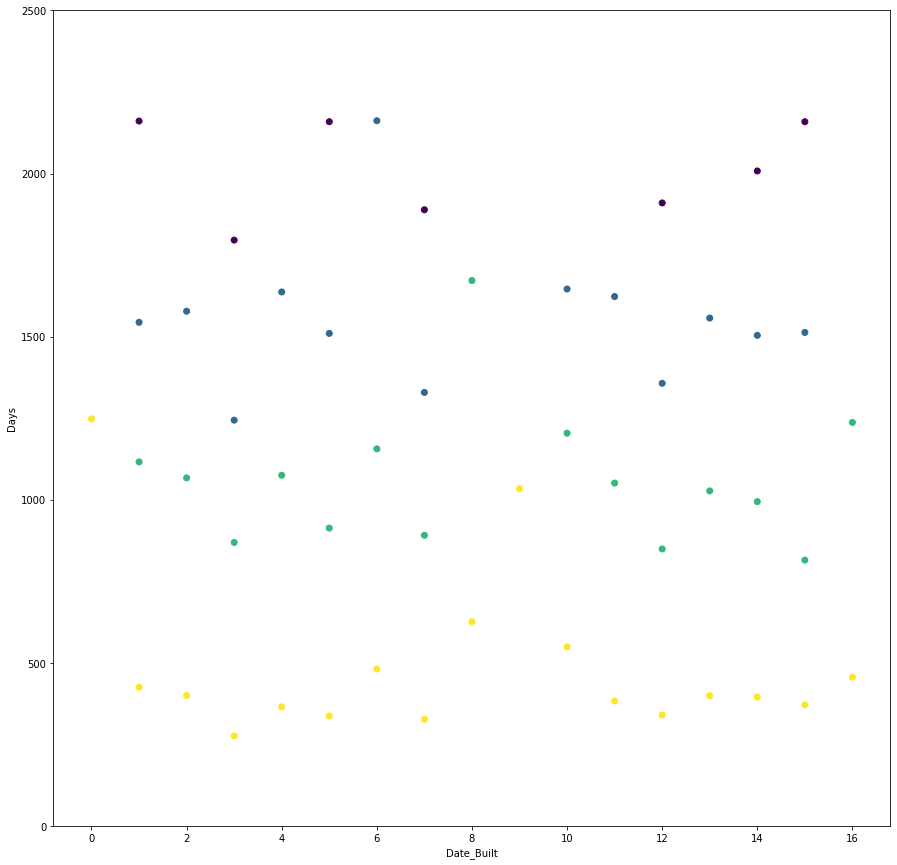

In [57]:
plt.figure(figsize=(15,15))
plt.scatter(cutoffs_built['Date_Built'], cutoffs_built['Days'],c=cutoffs_built['Cutoff'])
plt.ylim(ymin=0, ymax=2500)
plt.xlabel('Date_Built')
plt.ylabel('Days')
#plt.savefig("IMPORTANT")

In [58]:
compare3=pd.DataFrame()
for i in range(25):
    val3=1000*i
    val4=1000*i+1000
    df4=aaf.predict_survival_function(encoded_dataset.loc[(encoded_dataset['api_depth']>val1) & (encoded_dataset["api_depth"]<val2)])
    df4['mean'] = df4.mean(axis=1)
    compare3[str(i)]=df4['mean']

In [59]:
compare3

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
1.0,0.999451,0.999451,0.999451,0.999451,0.999451,0.999451,0.999451,0.999451,0.999451,0.999451,...,0.999451,0.999451,0.999451,0.999451,0.999451,0.999451,0.999451,0.999451,0.999451,0.999451
2.0,1.000898,1.000898,1.000898,1.000898,1.000898,1.000898,1.000898,1.000898,1.000898,1.000898,...,1.000898,1.000898,1.000898,1.000898,1.000898,1.000898,1.000898,1.000898,1.000898,1.000898
4.0,1.000928,1.000928,1.000928,1.000928,1.000928,1.000928,1.000928,1.000928,1.000928,1.000928,...,1.000928,1.000928,1.000928,1.000928,1.000928,1.000928,1.000928,1.000928,1.000928,1.000928
5.0,0.999692,0.999692,0.999692,0.999692,0.999692,0.999692,0.999692,0.999692,0.999692,0.999692,...,0.999692,0.999692,0.999692,0.999692,0.999692,0.999692,0.999692,0.999692,0.999692,0.999692
6.0,0.999107,0.999107,0.999107,0.999107,0.999107,0.999107,0.999107,0.999107,0.999107,0.999107,...,0.999107,0.999107,0.999107,0.999107,0.999107,0.999107,0.999107,0.999107,0.999107,0.999107
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28989.0,0.704211,0.704211,0.704211,0.704211,0.704211,0.704211,0.704211,0.704211,0.704211,0.704211,...,0.704211,0.704211,0.704211,0.704211,0.704211,0.704211,0.704211,0.704211,0.704211,0.704211
29368.0,0.677094,0.677094,0.677094,0.677094,0.677094,0.677094,0.677094,0.677094,0.677094,0.677094,...,0.677094,0.677094,0.677094,0.677094,0.677094,0.677094,0.677094,0.677094,0.677094,0.677094
31240.0,0.704693,0.704693,0.704693,0.704693,0.704693,0.704693,0.704693,0.704693,0.704693,0.704693,...,0.704693,0.704693,0.704693,0.704693,0.704693,0.704693,0.704693,0.704693,0.704693,0.704693
31799.0,0.674292,0.674292,0.674292,0.674292,0.674292,0.674292,0.674292,0.674292,0.674292,0.674292,...,0.674292,0.674292,0.674292,0.674292,0.674292,0.674292,0.674292,0.674292,0.674292,0.674292


In [60]:
store3=[]
for i in range(17):
    temp=list(compare3[str(i)])
    a=True
    b=True
    c=True
    d=True
    index=0
    temp2=[]
    while d and index<len(temp):
        if a and temp[index]<0.9:
            temp2.append(index)
            a=False
        if b and temp[index]<0.75:
            temp2.append(index)
            b=False
        if c and temp[index]<0.6:
            temp2.append(index)
            c=False
        if d and temp[index]<0.45:
            temp2.append(index)
            d=False
        index+=1
    store3.append(temp2)
    while len(temp2)!=4:
        temp2.append(25000)

In [61]:
cutoffs_depth=pd.DataFrame(columns=['Depth', 'Days', 'Cutoff'])
for i in range(17):
    for j in range(4):
        row=[]
        row.append(i)
        row.append(store3[i][j])
        if j==0:
            row.append(0.9)
        if j==1:
            row.append(0.75)
        if j==2:
            row.append(0.6)
        if j==3:
            row.append(0.45)
        cutoffs_depth.loc[len(cutoffs_depth.index)]=row

Text(0, 0.5, 'Days')

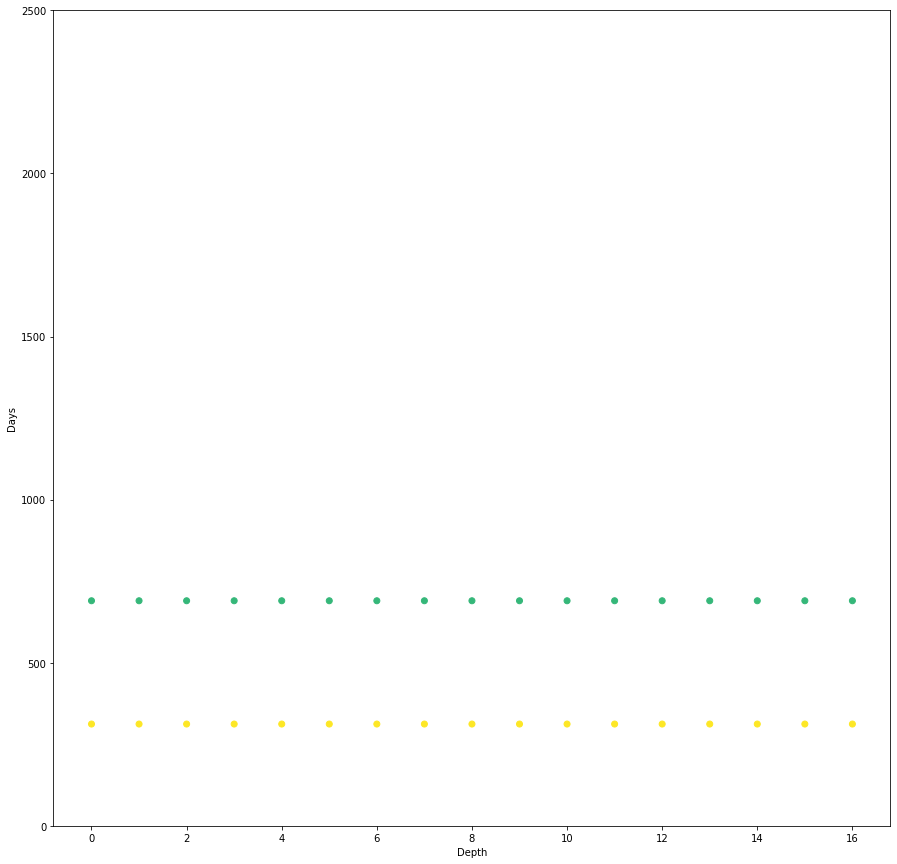

In [62]:
plt.figure(figsize=(15,15))
plt.scatter(cutoffs_depth['Depth'], cutoffs_depth['Days'],c=cutoffs_depth['Cutoff'])
plt.ylim(ymin=0, ymax=2500)
plt.xlabel('Depth')
plt.ylabel('Days')